# R kernel

In [1]:
suppressMessages({
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggpubr)
library(cowplot)
library(gridExtra)
library(rstatix)
library(reshape2)
library(ggnewscale)
library(RColorBrewer)
library(ComplexHeatmap)
library(SeuratDisk)
library(Seurat)
})

In [2]:
mytheme = function(){
theme_bw() +
theme(axis.text.x=element_text(size=5,color='black'),
    axis.text.y=element_text(size=5,color="black"),
    axis.title.y=element_text(size=5,color="black"),
    axis.title.x=element_text(size=5,color="black"),
    #axis.ticks.x=element_blank(),
    axis.ticks.length=unit(.02, "in"),
    axis.line = element_line(color = "black", linewidth = 0.25),
    axis.ticks = element_line(color = "black", size = 0.25),
    strip.text.x = element_text(size = 5,margin = margin(0.08,0,0.08,0, "cm")),
    strip.text.y = element_text(size = 5,margin = margin(0,0.08,0,0.08, "cm")),
    strip.background=element_rect(size=0.25),
    legend.text=element_text(size=5,color="black"),
    legend.title=element_text(size=5,color="black"),
    legend.key.width=unit(0.3,'cm'),
    legend.key.height=unit(0.3,'cm'),
    legend.box.margin=margin(0,0,0,2),
    legend.box.spacing = unit(0, "pt"),
    panel.spacing = unit(0.1, "cm"),
    plot.title = element_text(size=5),
    panel.border = element_rect(linewidth=0.25,color="black"),
    panel.grid = element_blank()
)
}

## Fig.2D

In [8]:
KC_celltype_order = c("Granular KC","Spinous KC-1","Spinous KC-2","Spinous KC-3","Spinous KC-4","Basal KC",
                      "IRS","ORS","OB", "HF-SG","Channel KC","Stress KC","Cycling KC")
group_order = c('HC','DLE','SLE')
group_color = c('HC' = '#d05204', 'DLE' = '#019167', 'SLE' = '#0166aa')

In [4]:
KC_celltype_colors = c(
    "Granular KC" = "#0089A3",
    "Spinous KC-1" = "#FF0000FF",
    "Spinous KC-2" = "#FF7F0EFF",
    "Spinous KC-3" = "#CCFF00FF",
    "Spinous KC-4" = "#EEC3FF",
    "Basal KC" = "#2CA02CFF",
    "IRS" = "#99CCFFFF",
    "ORS" = "#CC33FFFF",
    "OB" = "#FFCC00FF",
    "HF-SG" = "#FFFF00FF",
    "Channel KC" = "#A77500",
    "Stress KC" = "#00FFFFFF",
    "Cycling KC" = "#FF00CCFF"
)

In [173]:
ST_metadata = read.csv("All_samples_Cellbin_filter_gene200_add_anno_dist.csv",head=T, row.names=1)

In [174]:
KC_metadata <- subset(ST_metadata, celltype == "Keratinocytes")
all_stats <- KC_metadata %>%
  group_by(group,subtype) %>%
  summarise(count = n()) %>%
  mutate(percentage = count / sum(count) * 100)
all_stats$subtype = factor(all_stats$subtype, levels=KC_celltype_order)
all_stats$group = factor(all_stats$group, levels=c("HC","DLE","SLE"))

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


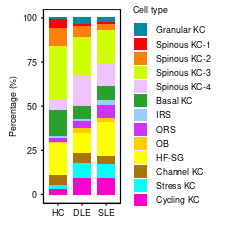

In [175]:
plot = ggplot(all_stats,aes(x=group,y=percentage,fill=subtype)) +
    geom_bar(stat = "identity",width=0.7) +
    labs(x="",y="Percentage (%)",fill="Cell type") +
    #guides(fill = guide_legend(override.aes = list(size=2), ncol = 1, title = 'Cell type')) +
    scale_fill_manual(values=KC_celltype_colors) +
    mytheme()
options(repr.plot.width= 1.9,repr.plot.height = 2)
plot

## Fig.2E

In [176]:
Epi_KC_rate = read.csv("Epi_KC_rate_depth.csv",head=T, row.names=1)
Depth_bin_order = c("(-0.001, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]", "(0.4, 0.5]", "(0.5, 0.6]", "(0.6, 0.7]", "(0.7, 0.8]", "(0.8, 0.9]", "(0.9, 1.0]")
Epi_KC_rate$Depth_bin = factor(Epi_KC_rate$Depth_bin, levels=rev(Depth_bin_order))
Epi_KC_rate$subtype = factor(Epi_KC_rate$subtype, levels=KC_celltype_order)

In [178]:
KC_need = c('Granular KC', 'ORS', 'OB', 'Stress KC', 'Cycling KC')

In [179]:
mean_sd <- Epi_KC_rate %>%
  group_by(group, Depth_bin, subtype) %>%
  summarize(mean_rate = mean(proportion), 
            sd_rate = sd(proportion),
            se_rate = sd(proportion) / sqrt(n())
           )
mean_sd$Depth_bin <- factor(mean_sd$Depth_bin, levels = rev(c("(-0.001, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]", "(0.4, 0.5]", "(0.5, 0.6]", "(0.6, 0.7]", "(0.7, 0.8]", "(0.8, 0.9]", "(0.9, 1.0]")))


`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.


In [180]:
mean_sd_need = mean_sd[mean_sd$subtype %in% KC_need,]
mean_sd_need$subtype = factor(mean_sd_need$subtype, levels=KC_need)
mean_sd_need$Depth_bin <- factor(mean_sd_need$Depth_bin, levels = rev(c("(-0.001, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]", "(0.4, 0.5]", "(0.5, 0.6]", "(0.6, 0.7]", "(0.7, 0.8]", "(0.8, 0.9]", "(0.9, 1.0]")))

In [32]:
plots = list()
for (i in 1:length(KC_need))
{
    stat.test.lst <- list()
    com_group.lst <- list()
    
    com_group.lst[[1]] <- c('HC', 'DLE')
    com_group.lst[[2]] <- c('HC', 'SLE')

    Epi_KC_subtype = subset(Epi_KC_rate, subtype == KC_need[i])
    
    for (com_group in com_group.lst){
        prefix = paste(com_group, collapse = '_vs_')

        Epi_KC_test <- Epi_KC_subtype[Epi_KC_subtype$group %in% com_group,]
        stat.test.lst[[prefix]] <- Epi_KC_test %>% group_by(Depth_bin) %>% wilcox_test(proportion ~ group, p.adjust.method = "none") %>% add_xy_position(x='Depth_bin')
        stat.test.lst[[prefix]]$p.signif = ifelse(stat.test.lst[[prefix]]$p <0.0001, '****',
                                    ifelse(stat.test.lst[[prefix]]$p <0.001 & stat.test.lst[[prefix]]$p > 0.0001, '***',
                                    ifelse(stat.test.lst[[prefix]]$p <0.01 & stat.test.lst[[prefix]]$p > 0.001, '**', 
                                    ifelse(stat.test.lst[[prefix]]$p <0.05 & stat.test.lst[[prefix]]$p > 0.01, '*','ns'
                                    ))))
    }
    
    stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =2.5)
    stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =2.5)
    
    if (KC_need[i] == 'Granular KC')
    {
        stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =3.5)
        stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =4)
    }

    if (KC_need[i] == 'Cycling KC')
    {
        stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position =8)
        stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position =9)
    }
    
    plots[[i]] <- ggline(Epi_KC_subtype, x="Depth_bin", y="proportion", add=c("mean_se"),  error.plot = "errorbar", 
                add.params = list(size = 1, width = 0.3),color = "group", palette = group_color, shape=20, stroke=NA, size=0.25,
                point.size = 0.1, nrow=1) +
    stat_pvalue_manual(stat.test.lst[['HC_vs_DLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#019167',label.size=3) + 
    stat_pvalue_manual(stat.test.lst[['HC_vs_SLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#0166aa',label.size=3) + 
    coord_flip() +
    labs(title=KC_need[i]) +
    mytheme() +
        theme(#axis.text.x=element_text(size=5,color="black",angle=90,hjust=1,vjust=0.5),
        axis.text.y=element_text(size=5,color="black"),
        axis.title=element_text(size=5,color="black"),
        plot.title=element_text(size=8,color="black"),
        strip.background=element_rect(size=0.25, color='black', fill="white"),
        panel.spacing = unit(0.15, "cm"),
        legend.position = "none"
    )
}

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


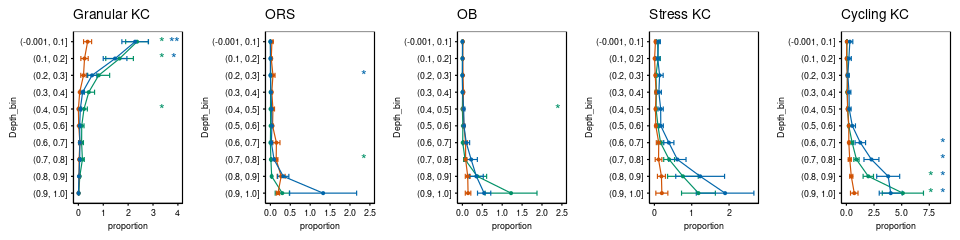

In [181]:
options(repr.plot.width =8,repr.plot.height = 2)
do.call(grid.arrange,c(plots,ncol=5))

## Fig.2F

In [182]:
KC_subtype_GO_all = read.csv("GO_AllLists.csv")

In [183]:
merge_GO_result = data.frame()
for (i in 1:length(KC_need))
{
    celltype_name = KC_need[i]
    celltype_name = gsub(" ","_",celltype_name)
    GO_result = KC_subtype_GO_all[grep(celltype_name,KC_subtype_GO_all$GeneList),]
    GO_result$celltype = KC_need[i]
    GO_result$group = ifelse(grepl("DLE",GO_result$GeneList),"DLE","SLE")
    merge_GO_result = rbind(merge_GO_result, GO_result)
}

In [184]:
Description_order <- c(
"keratinization",
"epidermis development",
"oxidative phosphorylation",
"innate immune response",
"cellular response to cytokine stimulus",
"regulation of apoptotic signaling pathway",
"response to type I interferon",
"response to type II interferon",
"antigen processing and presentation of endogenous peptide antigen",
"peptide antigen assembly with MHC class II protein complex",
"positive regulation of response to external stimulus",
"pattern recognition receptor signaling pathway",
"positive regulation of leukocyte cell-cell adhesion"
)

In [185]:
merge_GO_result$group <- factor(merge_GO_result$group, levels=c('DLE','SLE'))
GO_select <- merge_GO_result[merge_GO_result$Description %in% Description_order, ]
GO_select$celltype <- factor(GO_select$celltype, levels=KC_need)
GO_select$Description <- factor(GO_select$Description, levels=rev(Description_order))

In [186]:
short_data <- as.data.frame(pivot_wider(GO_select,id_cols=c(GeneList), names_from = Description, values_from = Log_q_value))
rownames(short_data) = short_data$GeneList
short_data_1 = short_data %>% dplyr::select(-c("GeneList"))
data_scaled <- as.data.frame(scale(short_data_1))
data_scaled = data_scaled %>% dplyr::select(Description_order)
data_scaled = t(data_scaled)

In [187]:
KC_subtype <- rep(KC_need, rep(2,length(KC_need)))

top_annotation = HeatmapAnnotation(
    "KC subtype" = KC_subtype, 
    simple_anno_size = unit(1.3, 'mm'), 
    col = list("KC subtype" = KC_celltype_colors),
    annotation_name_side = "left",
    annotation_name_gp = gpar(fontsize = 5),
    annotation_legend_param = list(
        "KC subtype" = list(
            title_gp = gpar(fontsize = 5), 
            labels_gp = gpar(fontsize = 5),
            grid_height = unit(3,'mm'),
            grid_width = unit(3,'mm')
        )
    )
) 

Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”
Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”
Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”


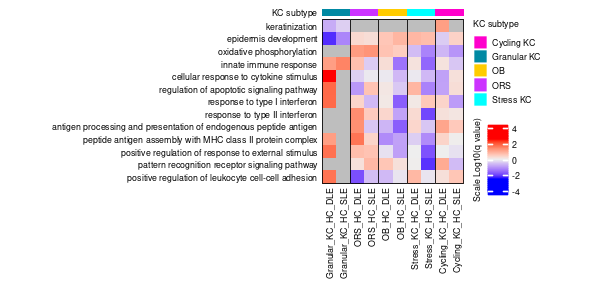

In [188]:
plot = Heatmap(data_scaled,cluster_rows = F, 
        cluster_columns = F, 
        
        heatmap_legend_param = list(
            legend_height = unit(1.2, "cm"),
            legend_width = unit(1, "cm"),
            title = "Scale Log10(q value)",
            title_position = "leftcenter-rot",
            title_gp=gpar(fontsize=5),
            labels_gp=gpar(fontsize=5)         
        ),
        show_parent_dend_line = FALSE,
        row_dend_reorder=FALSE,
        column_title = NULL,
        row_dend_width = unit(0.5, "cm"),
        row_names_gp = gpar(fontsize = 5),
        column_names_gp = gpar(fontsize = 5),
        row_dend_gp = gpar(lwd = 0.5),
        border = TRUE,
        row_names_side = "left",
        top_annotation = top_annotation,
        column_split = rep(seq_along(unique(KC_need)), each = 2),
        column_gap = unit(0, "mm"),
        border_gp = gpar(col = "black", lwd = 0.5),
        width = ncol(data_scaled)*unit(3, "mm"),
)

options(repr.plot.width =5,repr.plot.height =2.4)
draw(plot, merge_legend = TRUE)

## Fig.2H

In [88]:
KC_rds = readRDS("Keratinocyte_subtype.rds")

In [94]:
DefaultAssay(KC_rds) = 'RNA'
KC_rds = NormalizeData(KC_rds)

In [95]:
KC_rds$group = ifelse(grepl("D_SLE",KC_rds$orig.ident),"D_SLE",
            ifelse(grepl("E_SLE",KC_rds$orig.ident),"E_SLE",KC_rds$group))

In [91]:
genes = c("IFI6","IFI16","IFI27","IFI27L1","IFI27L2","IFI30","IFI35","IFI44","IFI44L","IFIH1","IFIT1","IFIT2","IFIT3","IFIT5","IFITM1","IFITM3","ISG15","ISG20",
             "IRF1","IRF2","IRF3","IRF7","IRF9",
             "OAS1","OAS2","OAS3",'OASL','GBP1','GBP2','GBP3','GBP4',"STAT1","STAT2","DDX58", "DDX60","MX1",'TRIM22','BST2',"TYK2", #'PARP8','PARP9','PARP10','PARP12','PARP14','APOL6',
            "IL18","IL20","IL34","IL36G",
            "CCL20","CCL27","CXCL2","CXCL3","CXCL9","CXCL10","CXCL11")

In [100]:
avg_expr = as.data.frame(AverageExpression(KC_rds, features= genes, group.by='group'))
avg_expr = avg_expr[,c('RNA.E_HC','RNA.E_DLE','RNA.E_SLE')]
colnames(avg_expr) = gsub("RNA.E_","",colnames(avg_expr))
data_scaled <- as.data.frame(scale(t(avg_expr)))

In [113]:
gene_class <- rep(c('IFN related genes', 'Cytokine','Chemokine'), c(39,4,7))

top_annotation = rowAnnotation(
    Gene = gene_class, 
    simple_anno_size = unit(2, 'mm'), 
    col = list(Gene = c('IFN related genes' = 2, 'Cytokine' = 3, 'Chemokine' = 4)),
    annotation_name_gp = gpar(fontsize = 5),
    annotation_legend_param = list(
        Gene = list(
            title_gp = gpar(fontsize = 5), 
            labels_gp = gpar(fontsize = 5),
            grid_height = unit(3,'mm'),
            grid_width = unit(3,'mm')
        )
    )
)

Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”
Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”
Warning message:
“`legend_height` you specified is too small, use the default minimal
height.”


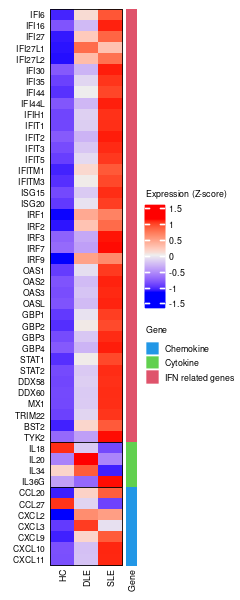

In [114]:
plot = Heatmap(t(data_scaled),cluster_rows = F, 
        cluster_columns = F, 
        heatmap_legend_param = list(
            title = "Expression (Z-score)",
            legend_height = unit(1, "cm"),
            legend_width = unit(1.5, "cm"),
            annotation_legend_side = "bottom",
            heatmap_legend_side = "bottom",
            labels_gp=gpar(fontsize=5),
            title_gp=gpar(fontsize=5)
        ),
        show_parent_dend_line = FALSE,
        row_dend_reorder=FALSE,
        row_title = NULL,
        row_dend_width = unit(0.5, "cm"),
        row_names_gp = gpar(fontsize = 4.8),
        column_names_gp = gpar(fontsize = 5),
        row_dend_gp = gpar(lwd = 0.5),
        column_gap = unit(0.7, "mm"),
        border_gp = gpar(col = "black", lwd = 0.5),
        row_split = rep(1:3, c(39,4,7)),
        row_gap = unit(0, "mm"),
        border = TRUE,
        row_names_side = "left",
        right_annotation = top_annotation,
        )

options(repr.plot.width =2,repr.plot.height =5)
draw(plot, merge_legend = TRUE)

## Fig.2G

In [192]:
Epi_gene_set_score = read.csv("Epi_gene_set_score_new.csv",head=T,row.names=1)
Epi_gene_set_score$group = factor(Epi_gene_set_score$group, levels=c("HC","DLE","SLE"))

In [193]:
gene_sets = c('Ker_score','OP_score', 'INFA_score')
Epi_gene_set_score_need = Epi_gene_set_score[,colnames(Epi_gene_set_score) %in% c(gene_sets,"group","sample")]

In [194]:
Epi_gene_set_score_melt = melt(Epi_gene_set_score_need)
Epi_gene_set_score_melt$variable = factor(Epi_gene_set_score_melt$variable, levels=gene_sets)

Using sample, group as id variables



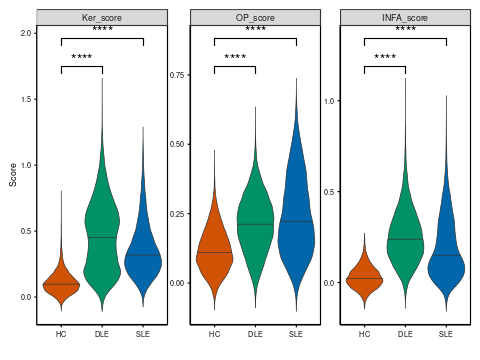

In [195]:
plot = ggplot(Epi_gene_set_score_melt, aes(x=group,y=value,fill=group)) +
        facet_wrap(.~variable, ncol=3, scale='free') +
        geom_violin(scale='width', lwd=0.15,draw_quantiles = 0.5) + 
        stat_compare_means(comparisons=list(c('HC','DLE'),c('HC','SLE')), size=2.8, bracket.size=0.25, method='wilcox.test', label = 'p.signif') + 
        labs(x="",y='Score') +
        #scale_y_continuous(limits = c(50,500)) +
        scale_fill_manual(values=group_color) +
        mytheme() + 
        theme(
            axis.text.y=element_text(size=4,color='black'),
            axis.text.x=element_text(size=4,color='black'),
            legend.position = 'none'
              #panel.border = element_blank(),
             #strip.text.x = element_blank()
        )

options(repr.plot.width =4,repr.plot.height = 3)
plot

In [141]:
samples = c('HC1', 'HC2','HC3', 'HC4', 'DLE1','DLE2','DLE3','DLE4','DLE5','SLE1','SLE2','SLE3','SLE4','SLE5','SLE6')
gene_set_score_new = data.frame()
for (i in 1:length(samples))
{
    gene_set_score_test = Epi_gene_set_score[Epi_gene_set_score$sample==samples[i],]
    gene_set_score_test$depth = gene_set_score_test$distance2Epi/max(gene_set_score_test$distance2Epi)
    gene_set_score_new = rbind(gene_set_score_new,gene_set_score_test)
}

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


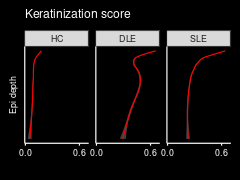

In [166]:
plot = ggplot(gene_set_score_new, aes(x=depth,y=Ker_score)) +
geom_smooth(linewidth=0.25, color = 'red') +
facet_wrap(.~group, scale = 'free_y') +
ggtitle("Keratinization score") +
coord_flip() +
scale_x_continuous(breaks=seq(0,1,1)) +
scale_x_reverse()+
scale_y_continuous(breaks=seq(0,0.6,0.6)) +
labs(x="Epi depth") +
mytheme() +
theme(axis.text.y=element_blank(), 
    axis.ticks.y=element_blank(), 
    axis.title.y=element_text(color = 'white',size=5),
    axis.text.x=element_text(color = 'white',size=5),
    axis.line = element_line(color = "white", linewidth = 0.25),
    axis.ticks = element_line(color = "white", size = 0.25),
    panel.border = element_blank(), 
    plot.background = element_rect(fill='black',colour = 'black'),
    panel.background = element_rect(fill='black',colour = 'black'),
    plot.title = element_text(size=7,color='white')
)

options(repr.plot.width =2,repr.plot.height = 1.5)
plot

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


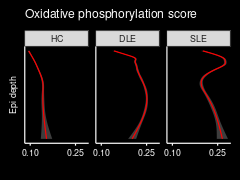

In [161]:
plot = ggplot(gene_set_score_new, aes(x=depth,y=OP_score)) +
geom_smooth(linewidth=0.25, color = 'red') +
facet_wrap(.~group, scale = 'free_y') +
ggtitle("Oxidative phosphorylation score") +
coord_flip() +
scale_x_continuous(breaks=seq(0,1,1)) +
scale_x_reverse()+
scale_y_continuous(breaks=seq(0.1,0.25,0.15)) +
labs(x="Epi depth") +
mytheme() +
theme(axis.text.y=element_blank(), 
    axis.ticks.y=element_blank(), 
    axis.title.y=element_text(color = 'white',size=5),
    axis.text.x=element_text(color = 'white',size=5),
    axis.line = element_line(color = "white", linewidth = 0.25),
    axis.ticks = element_line(color = "white", size = 0.25),
    panel.border = element_blank(), 
    plot.background = element_rect(fill='black',colour = 'black'),
    panel.background = element_rect(fill='black',colour = 'black'),
    plot.title = element_text(size=7,color='white')
)

options(repr.plot.width =2,repr.plot.height = 1.5)
plot

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


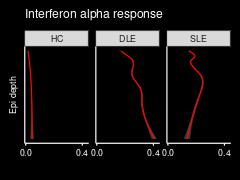

In [167]:
plot = ggplot(gene_set_score_new, aes(x=depth,y=INFA_score)) +
geom_smooth(linewidth=0.25, color = 'red') +
facet_wrap(.~group, scale = 'free_y') +
ggtitle("Interferon alpha response") +
coord_flip() +
scale_x_continuous(breaks=seq(0,1,1)) +
scale_x_reverse()+
scale_y_continuous(breaks=seq(0,0.4,0.4)) +
labs(x="Epi depth") +
mytheme() +
theme(axis.text.y=element_blank(), 
    axis.ticks.y=element_blank(), 
    axis.title.y=element_text(color = 'white',size=5),
    axis.text.x=element_text(color = 'white',size=5),
    axis.line = element_line(color = "white", linewidth = 0.25),
    axis.ticks = element_line(color = "white", size = 0.25),
    panel.border = element_blank(), 
    plot.background = element_rect(fill='black',colour = 'black'),
    panel.background = element_rect(fill='black',colour = 'black'),
    plot.title = element_text(size=7,color='white')
)

options(repr.plot.width =2,repr.plot.height = 1.5)
plot

## Fig.2I

In [5]:
gene_expr = read.csv("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Celltype_analysis/KC/Epi_depth_bin_gene_exp.csv",head=T, row.names=1)

In [6]:
genes = c('IL36G', 'CXCL10', 'IFIH1')

In [16]:
plots = list()
for (i in 1:length(genes))
{
    stat.test.lst <- list()
    com_group.lst <- list()
    
    com_group.lst[[1]] <- c('HC', 'DLE')
    com_group.lst[[2]] <- c('HC', 'SLE')

    gene_expr_sub = subset(gene_expr, gene == genes[i])
    
    for (com_group in com_group.lst){
        prefix = paste(com_group, collapse = '_vs_')

        gene_expr_sub_test <- gene_expr_sub[gene_expr_sub$group %in% com_group,]
        stat.test.lst[[prefix]] <- gene_expr_sub_test %>% group_by(Depth_bin) %>% wilcox_test(expression ~ group, p.adjust.method = "none") %>% add_xy_position(x='Depth_bin')
        stat.test.lst[[prefix]]$p.signif = ifelse(stat.test.lst[[prefix]]$p <0.0001, '****',
                                    ifelse(stat.test.lst[[prefix]]$p <0.001 & stat.test.lst[[prefix]]$p > 0.0001, '***',
                                    ifelse(stat.test.lst[[prefix]]$p <0.01 & stat.test.lst[[prefix]]$p > 0.001, '**', 
                                    ifelse(stat.test.lst[[prefix]]$p <0.05 & stat.test.lst[[prefix]]$p > 0.01, '*','ns'
                                    ))))
    }

    mean_sd <- gene_expr_sub %>%
            group_by(group, Depth_bin, gene) %>%
            summarize(mean_expr = mean(expression), 
            se_expr = sd(expression) / sqrt(n()),
            sum = mean_expr + se_expr)
                      
    stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position = max(mean_sd$sum) + 0.1*max(mean_sd$sum))
    stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position = max(mean_sd$sum) + 0.2*max(mean_sd$sum))
 
    plots[[i]] <- ggline(gene_expr_sub, x="Depth_bin", y="expression", add=c("mean_se"),  error.plot = "errorbar", 
                add.params = list(size = 1, width = 0.3),color = "group", palette = group_color, shape=20, stroke=NA, size=0.25,
                point.size = 0.1, nrow=1) + 
    stat_pvalue_manual(stat.test.lst[['HC_vs_DLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#019167',label.size=2) + 
    stat_pvalue_manual(stat.test.lst[['HC_vs_SLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#0166aa',label.size=2) + 
    ggtitle(genes[i]) +
    labs(y='Expression Levels', x='Epi depth') +
    mytheme() +
        theme(axis.text.x=element_text(size=5,color="black",angle=90,hjust=1,vjust=0.5),
        axis.text.y=element_text(size=5,color="black"),
        axis.title=element_text(size=5,color="black"),
        plot.title=element_text(size=6,color="black"),
        strip.background=element_rect(linewidth=0.25, color='black', fill="white"),
        panel.spacing = unit(0.15, "cm"),
        legend.position = "none"
    )
}

`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


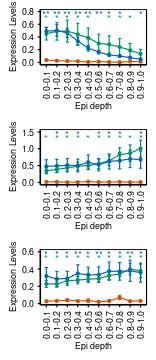

In [17]:
options(repr.plot.width =1.3,repr.plot.height = 3)
do.call(grid.arrange,c(plots,ncol=1))

# Python kernel

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
from shapely.geometry import GeometryCollection, Polygon
import importlib

import utils_20250718
importlib.reload(utils_20250718)
from utils_20250718 import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
KC_celltype_order = ["Granular KC","Spinous KC-1","Spinous KC-2","Spinous KC-3","Spinous KC-4","Basal KC",
                      "IRS","ORS","OB", "HF-SG","Channel KC","Stress KC","Cycling KC"]

In [3]:
KC_celltype_colors = {
    "Granular KC" : "#0089A3",
    "Spinous KC-1" : "#FF0000FF",
    "Spinous KC-2" : "#FF7F0EFF",
    "Spinous KC-3" : "#CCFF00FF",
    "Spinous KC-4" : "#EEC3FF",#"#FFCCCCFF",
    "Basal KC" : "#2CA02CFF",
    "IRS" : "#99CCFFFF",
    "ORS" : "#CC33FFFF",
    "OB" : "#FFCC00FF",
    "HF-SG" : "#FFFF00FF",
    "Channel KC" : "#A77500",
    "Stress KC" : "#00FFFFFF",
    "Cycling KC" : "#FF00CCFF"
}

In [248]:
KC_adata = sc.read("SC_Keratinocyte_subtype.h5ad")

In [249]:
sc.pp.normalize_total(KC_adata, target_sum=10000)
sc.pp.log1p(KC_adata)

In [250]:
KC_adata.obs['subtype'] = pd.Categorical(KC_adata.obs['subtype'], categories=KC_celltype_order)

In [4]:
ST_adata = sc.read_h5ad('All_samples_Cellbin_filter_gene200_add_anno_dist.h5ad')
sc.pp.normalize_total(ST_adata, target_sum=10000)
sc.pp.log1p(ST_adata)

## Fig.2A

[18:30:53] 📃  add palette for `subtype` to adata.uns                                        ]8;id=44861;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=170521;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#1526\1526]8;;\

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

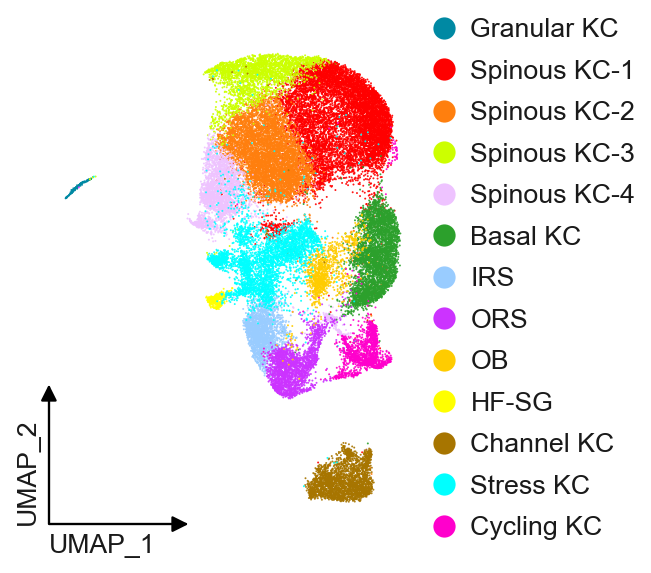

In [252]:
dimplot(KC_adata, groupby="subtype", reduction='X_umap', arrow=True, palette=KC_celltype_colors)

## Fig.2B

In [253]:
KC_marker_gene = [
"FLG","CNFN","LCE1F", # Granulosum KC
"KRT1","LYAR","SPSB1","HSPA6","CHP2","KRT2","CD24","FABP5","PLCG2", #Spinosum KC
'KRT15','KRT14',"COL17A1", #Basal KC
'KRT75','KRT17', #IRS
'POSTN','LGR5', #ORS
'FST','PTHLH', #OB
'KRT79','APOC1','MGST1', #HF-SG
"GJB6",'ATP1B1','GJB2', #Channel KC
'KRT6B','S100A8','CXCL10', #Stress KC
"MKI67",'TOP2A',"UBE2C" # Cycling KC
]

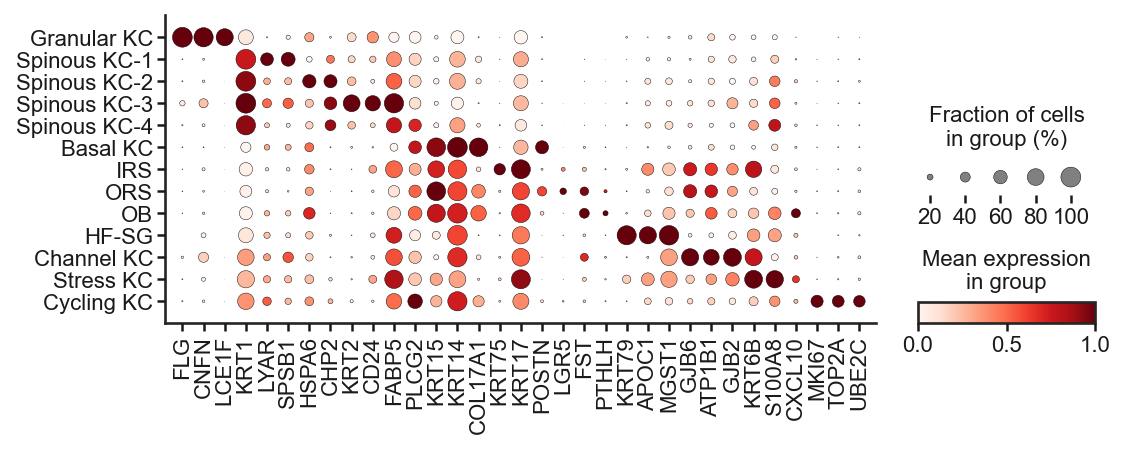

In [254]:
axes_dict = sc.pl.dotplot(KC_adata, KC_marker_gene, groupby='subtype', figsize=(7.5,2.5), standard_scale='var',show=False, return_fig=True, use_raw=False)
axes_dict.style(largest_dot=80, cmap='Reds')
axes_dict.show()

## Fig.2C

In [6]:
SLE2_adata = ST_adata[ST_adata.obs['sample'] == 'SLE2']

In [7]:
SLE2_BM_shp = gpd.read_file("SLE2_BM_tussue_contour.shp")

In [257]:
polygon1 = Polygon([[19000,17800], [21000,17800],[21000,16800], [19000,16800]])
polygon2 = Polygon([[16000,18100], [17000,18100],[17000,17100], [16000,17100]])
polygon3 = Polygon([[11600,16800], [12600,16800],[12600,15800], [11600,15800]])
polygon4 = Polygon([[15000,14600], [15600,14600],[15600,14000], [15000,14000]])

[18:31:28] ❕  ssat is not registered, register now                                           ]8;id=506495;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=100415;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:287: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:31:29] 📃  add palette for `subtype` to adata.uns                                        ]8;id=509746;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=530738;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#1526\1526]8;;\

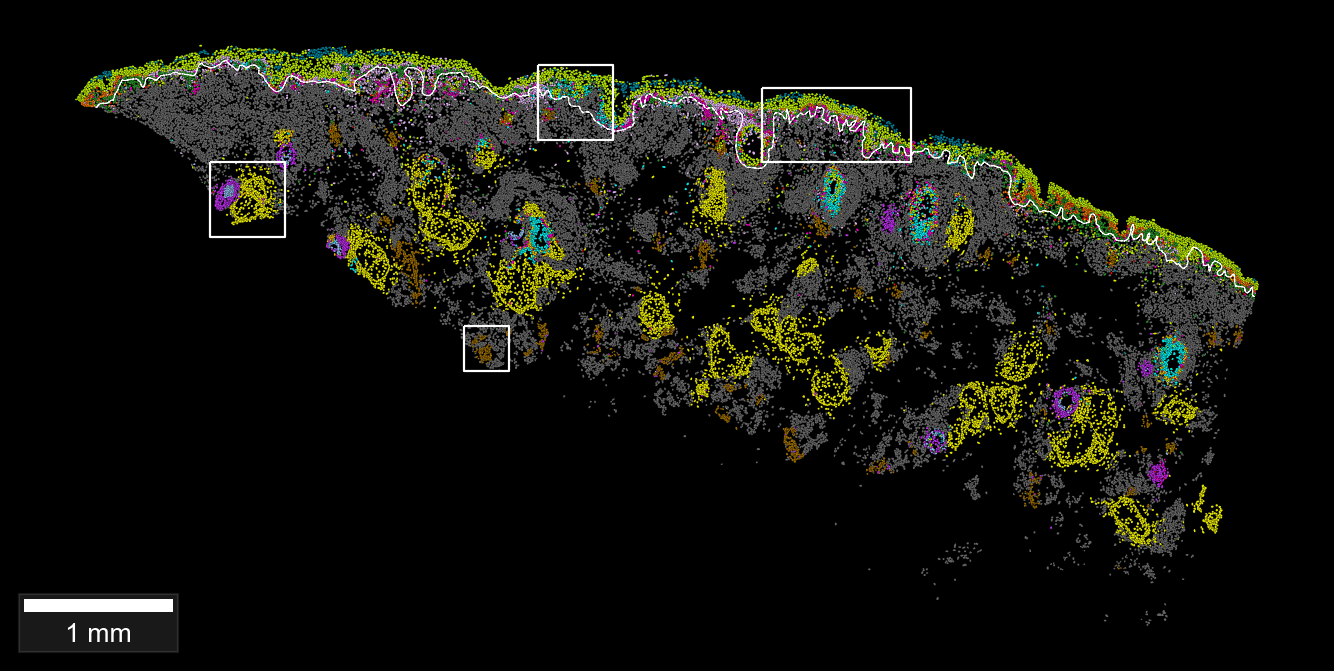

In [258]:
with mpl.style.context("dark_background"): 
    ax = dimplot(SLE2_adata, background=True, groupby="subtype", reduction="contour",height=10,dot_size=10,legend=False,order = KC_celltype_order,palette=KC_celltype_colors) #,
    SLE2_BM_shp.rotate(0, origin=(0,0)).plot(ax=ax, edgecolor='white',facecolor='none', linestyle='--', linewidth=0.5)
    gpd.GeoSeries(polygon1).plot(ax=ax, facecolor='none', edgecolor='white')
    gpd.GeoSeries(polygon2).plot(ax=ax, facecolor='none', edgecolor='white')
    gpd.GeoSeries(polygon3).plot(ax=ax, facecolor='none', edgecolor='white')
    gpd.GeoSeries(polygon4).plot(ax=ax, facecolor='none', edgecolor='white')
    draw_scalebar(ax=ax, color='white',location='lower left')

In [34]:
zone1 = [19000,16800,21000,17800]
zone2 = [16000,17100,17000,18100]
zone3 = [11600,15800,12600,16800]
zone4 = [15000,14000,15600,14600]

[23:12:11] 📃  Filtering contour within bounding box [19000, 16800, 21000, 17800]            ]8;id=460214;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=763890;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=187734;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=243176;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:287: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ssat'] = SSAT_PARAMS


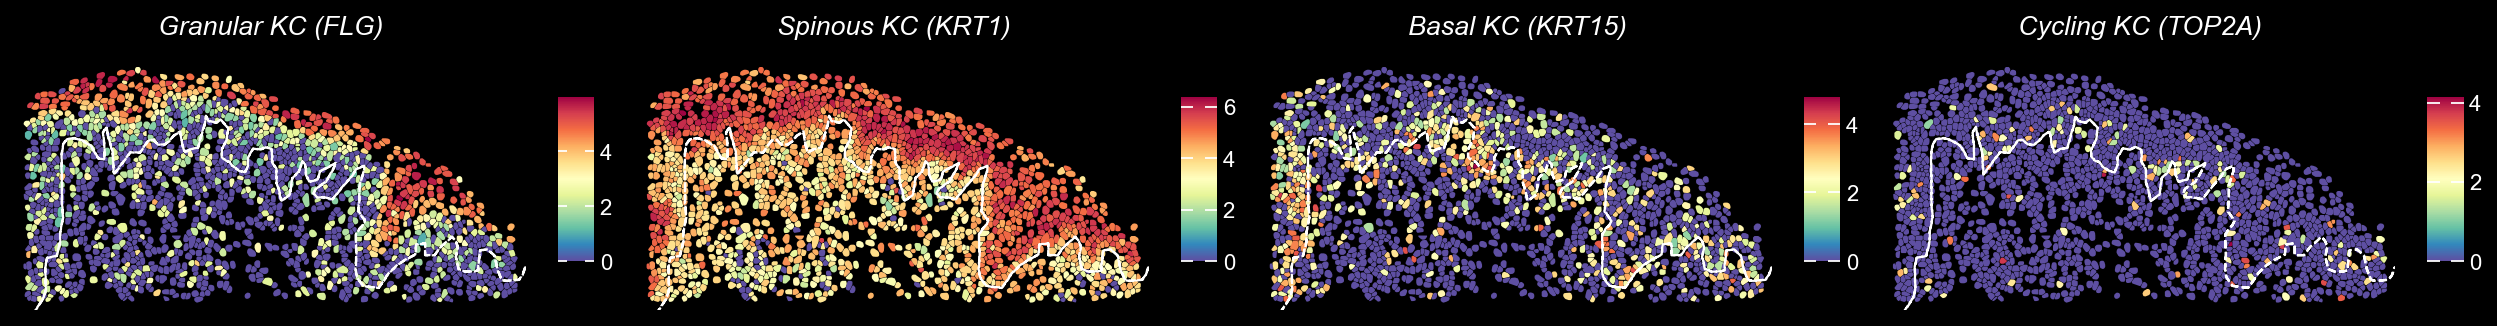

In [30]:
genes = ['FLG','KRT1','KRT15','TOP2A']
KC_subtypes = ["Granular KC","Spinous KC","Basal KC", "Cycling KC"]

zone1_adata = within(SLE2_adata, zone1, reduction='contour', inplace=True)

with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(
        nrows=1,
        ncols=4,
        figsize=(4 * len(genes), 4),
        #squeeze=False
    )
    for i, gene in enumerate(genes): 
        ax = axs[i]     
        ax = featureplot(zone1_adata, features=gene, reduction='contour', ax=ax,style='dark_background')
        SLE2_BM_shp.plot(ax=ax, edgecolor='white',facecolor='none', linestyle='--', linewidth=1)
        ax.set_title(f"{KC_subtypes[i]} ({genes[i]})")
        ax.set_xlim([zone1[0]-30,zone1[2]+30])
        ax.set_ylim([zone1[1]-30,zone1[3]+30])
        ax.axis("off")
    plt.tight_layout(pad=1.0)
    plt.show()

[16:16:51] 📃  Filtering contour within bounding box [16000, 17100, 17000, 18100]            ]8;id=7718;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=592811;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=361528;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=337086;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


Text(0.5, 1.0, 'Stress KC (CXCL10)')

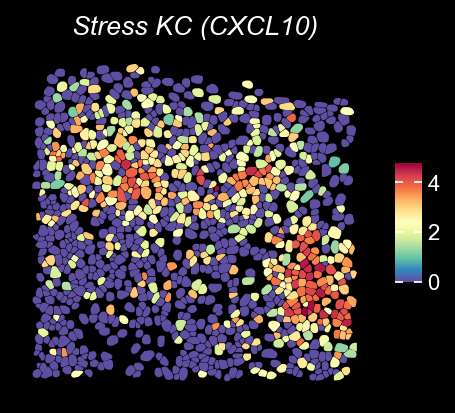

In [138]:
zone2_adata = within(SLE2_adata, zone2, reduction='contour', inplace=True)
ax = featureplot(zone2_adata, ['CXCL10'], reduction='contour',style='dark_background')
ax.set_title("Stress KC (CXCL10)")

[23:13:45] 📃  Filtering contour within bounding box [11600, 15800, 12600, 16800]            ]8;id=166576;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=754875;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=964497;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=966884;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:287: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ssat'] = SSAT_PARAMS


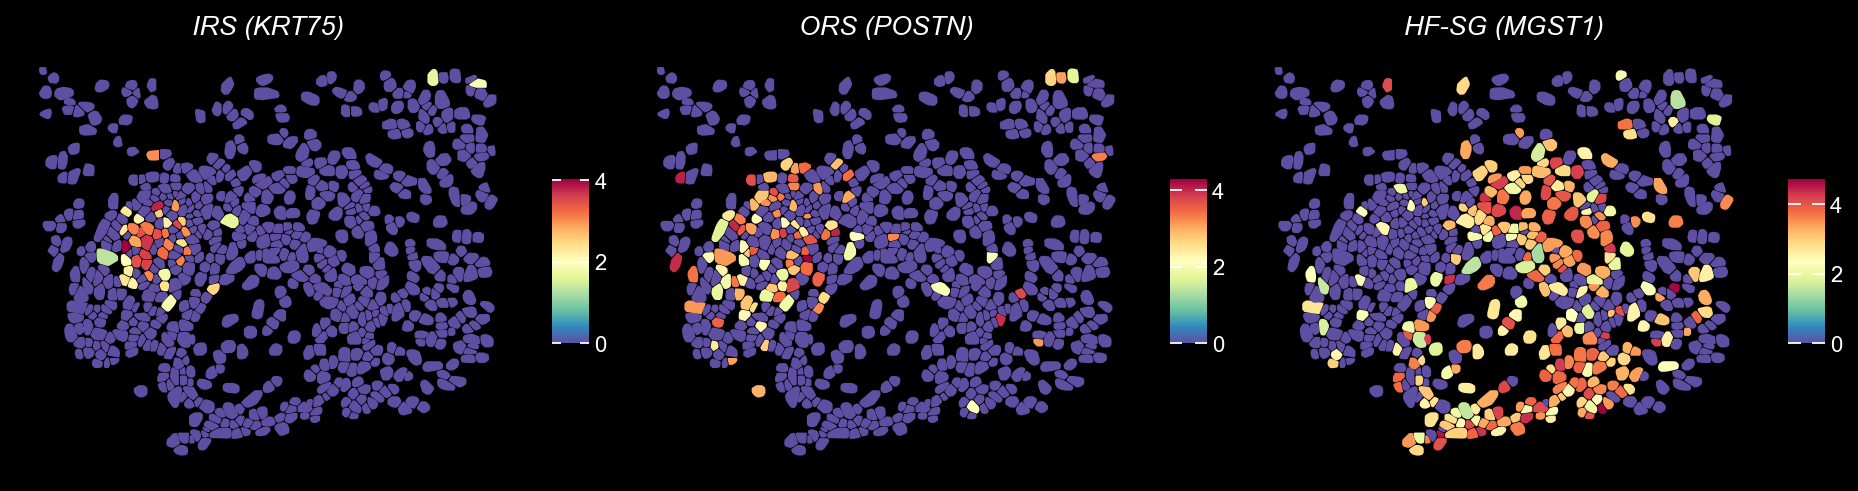

In [33]:
genes = ['KRT75','POSTN','MGST1']
KC_subtypes = ["IRS","ORS", "HF-SG"]
zone3_adata = within(SLE2_adata, zone3, reduction='contour', inplace=True)

with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(4 * len(genes), 4),
        #squeeze=False
    )
    for i, gene in enumerate(genes): 
        ax = axs[i]     
        ax = featureplot(zone3_adata, features=gene, reduction='contour', ax=ax,style='dark_background')
        ax.set_title(f"{KC_subtypes[i]} ({genes[i]})")
        ax.axis("off")
    plt.tight_layout(pad=1.0)
    plt.show()

[16:15:45] 📃  Filtering contour within bounding box [15000, 14000, 15600, 14600]            ]8;id=201568;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=696708;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=257396;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=72375;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


Text(0.5, 1.0, 'Channel KC (GJB2)')

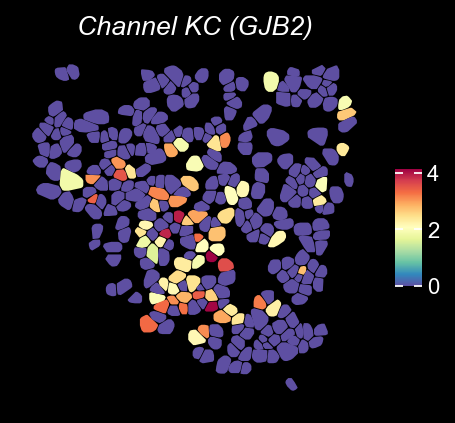

In [136]:
zone4_adata = within(SLE2_adata, zone4, reduction='contour', inplace=True)
ax = featureplot(zone4_adata, ['GJB2'], reduction='contour',style='dark_background')
ax.set_title("Channel KC (GJB2)")

## Fig.2G

In [37]:
msigdb_GO = pd.read_csv("msigdb_GO_v2024.1.Hs.csv")
Ker_gene = msigdb_GO[msigdb_GO['geneset'] == 'GOBP_KERATINIZATION']

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


[23:20:29] ❕  ssat is not registered, register now                                           ]8;id=929040;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=724898;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


[23:20:30] ❕  ssat is not registered, register now                                           ]8;id=821079;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=911338;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


           ❕  ssat is not registered, register now                                           ]8;id=155762;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=990902;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

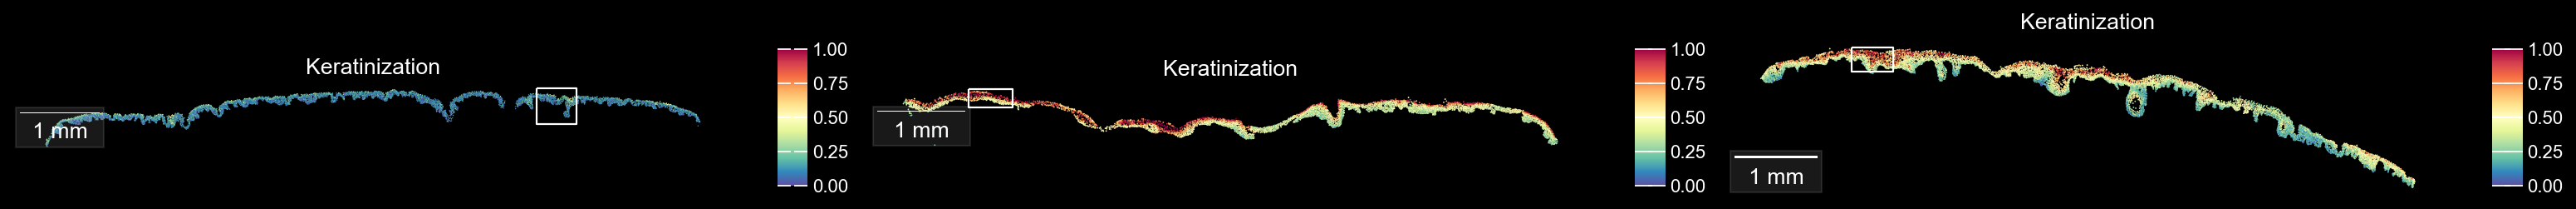

In [44]:
polygons = {
    "HC2": [Polygon([[14600, 19400], [15600, 19400], [15600, 18500], [14600, 18500]])],
    "DLE4": [Polygon([[7000, 17350], [8000, 17350], [8000, 16950], [7000, 16950]])],
    "SLE2": [Polygon([[12000,18400], [13000,18400],[13000,17800], [12000,17800]])]
}

rows, cols = 1, 3
fig = None
axs = None
plot_count = 0

samples = ["HC2","DLE4","SLE2"]
for i in range(len(samples)):
    sample_adata = ST_adata[(ST_adata.obs['sample'] == samples[i]) & (ST_adata.obs['Region'] == 'Epi')]
    sc.tl.score_genes(sample_adata, Ker_gene['gene'], score_name ='Ker_score', ctrl_size=100)
    
    if plot_count % (rows*cols) == 0:
        with mpl.style.context('dark_background'):
            if fig is not None:
                plt.tight_layout(pad=1.0)
                plt.close(fig)
            fig = plt.figure(figsize=(20, 4))
            axs = fig.subplots(rows, cols)
            axs = axs.ravel()   
    ax = axs[plot_count % (rows*cols)]
    
    ax = featureplot(sample_adata, features='Ker_score', reduction='spatial', dot_size=100, vmin = 0, vmax = 1,vcenter=0.5, ax=ax, style="dark_background")
    draw_scalebar(ax=ax, color='white', location='lower left')
    ax.set_title(f"Keratinization")
    for polygon in polygons[samples[i]]:
        gpd.GeoSeries(polygon).plot(ax=ax, edgecolor='white',facecolor='none', linewidth=1) #linestyle='--',
    plot_count += 1
    
if fig is not None:
    for j in range(plot_count % (rows*cols), rows*cols):
        axs[j].axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()        #squeeze=False


/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


[23:19:58] 📃  Filtering contour within bounding box [14600, 18500, 15600, 19400]            ]8;id=834606;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=641334;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=808201;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=311986;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:287: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ssat'] = SSAT_PARAMS


/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


[23:19:59] 📃  Filtering contour within bounding box [7000, 16950, 8000, 17350]              ]8;id=653244;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=635375;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=195061;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=79315;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:287: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ssat'] = SSAT_PARAMS


/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


[23:20:00] 📃  Filtering contour within bounding box [12000, 17800, 13000, 18400]            ]8;id=51143;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=458073;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=630149;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=55524;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#286\286]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:287: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ssat'] = SSAT_PARAMS


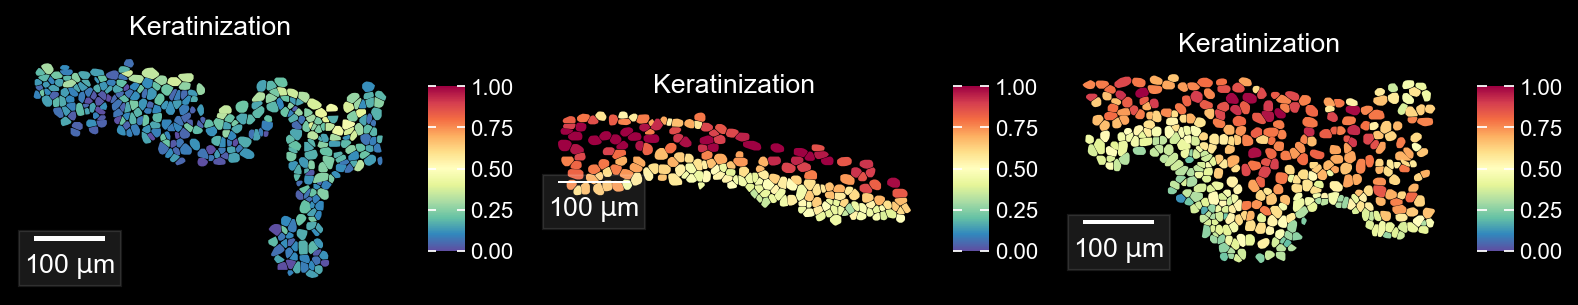

In [43]:
zone = {
'HC2' : [14600,18500,15600,19400],
'DLE4' : [7000,16950,8000,17350],
'SLE2' : [12000,17800,13000,18400]
}


rows, cols = 1, 3
fig = None
axs = None
plot_count = 0


samples = ["HC2","DLE4","SLE2"]
for i in range(len(samples)):
    sample_adata = ST_adata[(ST_adata.obs['sample'] == samples[i]) & (ST_adata.obs['Region'] == 'Epi')]
    sc.tl.score_genes(sample_adata, Ker_gene['gene'], score_name ='Ker_score', ctrl_size=100)
    zone_adata = within(sample_adata, zone[samples[i]], reduction='contour', inplace=True)
        
    if plot_count % (rows*cols) == 0:
        with mpl.style.context('dark_background'):
            if fig is not None:
                plt.tight_layout(pad=1.0)
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)
            fig = plt.figure(figsize=(10, 4))
            axs = fig.subplots(rows, cols)
            axs = axs.ravel()   
    ax = axs[plot_count % (rows*cols)]
    
    ax = featureplot(zone_adata, features='Ker_score', reduction='contour', dot_size=100, vmin = 0, vmax = 1,vcenter=0.5, ax=ax, style="dark_background") 
    draw_scalebar(ax=ax, color='white',location='lower left')
    ax.set_title(f"Keratinization")
    plot_count += 1
    
if fig is not None:
    for j in range(plot_count % (rows*cols), rows*cols):
        axs[j].axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()


In [139]:
Hallmark_gene = pd.read_csv("Human_hallmark_gene_sets_v2023.2.csv")

In [140]:
OP_gene = Hallmark_gene[Hallmark_gene['HallmarkName'] == 'HALLMARK_OXIDATIVE_PHOSPHORYLATION']

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:43:20] ❕  ssat is not registered, register now                                           ]8;id=380789;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=413815;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


           ❕  ssat is not registered, register now                                           ]8;id=416207;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=77060;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:43:21] ❕  ssat is not registered, register now                                           ]8;id=776287;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=464760;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

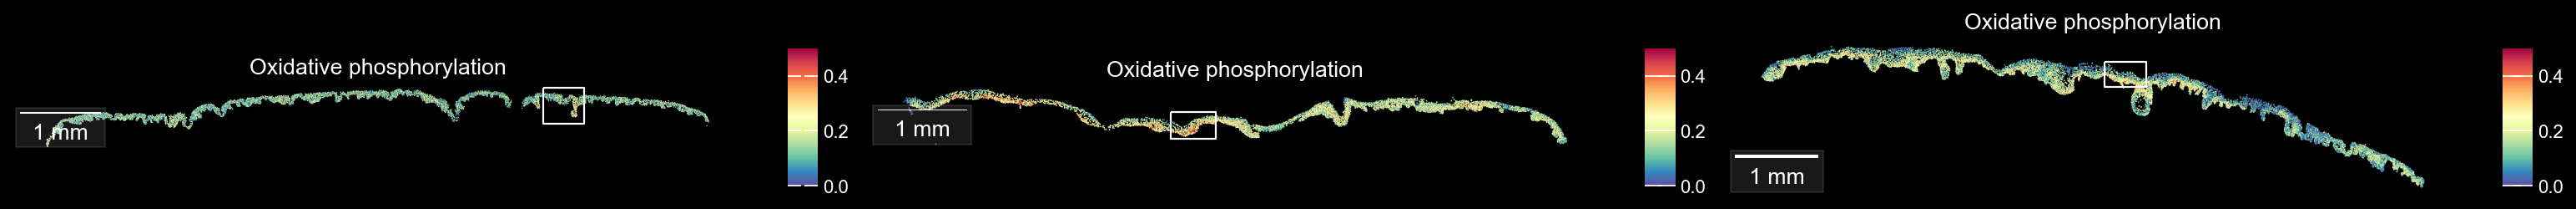

In [202]:
polygons = {
    "HC2": [Polygon([[14600, 19400], [15600, 19400], [15600, 18500], [14600, 18500]])],
    "DLE4": [Polygon([[11500, 16800], [12500, 16800], [12500, 16200], [11500, 16200]])],
    "SLE2": [Polygon([[18000,18000], [19000,18000],[19000,17400], [18000,17400]])]
}

rows, cols = 1, 3
fig = None
axs = None
plot_count = 0

samples = ["HC2","DLE4","SLE2"]
for i in range(len(samples)):
    sample_adata = ST_adata[(ST_adata.obs['sample'] == samples[i]) & (ST_adata.obs['Region'] == 'Epi')]
    sc.tl.score_genes(sample_adata, OP_gene['Genesymbol'], score_name ='OP_score', ctrl_size=100)
    
    if plot_count % (rows*cols) == 0:
        with mpl.style.context('dark_background'):
            if fig is not None:
                plt.tight_layout(pad=1.0)
                #pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)
            fig = plt.figure(figsize=(20, 4))
            axs = fig.subplots(rows, cols)
            axs = axs.ravel()   
    ax = axs[plot_count % (rows*cols)]
    
    ax = featureplot(sample_adata, features='OP_score', reduction='spatial', dot_size=100, height=5,vmin = 0, vmax = 0.5,vcenter=0.25,  ax=ax, style='dark_background')
    draw_scalebar(ax=ax, color='white', location='lower left')
    ax.set_title(f"Oxidative phosphorylation")
    for polygon in polygons[samples[i]]:
        gpd.GeoSeries(polygon).plot(ax=ax, edgecolor='white',facecolor='none', linewidth=1) #linestyle='--',
    plot_count += 1
    
if fig is not None:
    for j in range(plot_count % (rows*cols), rows*cols):
        axs[j].axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:42:54] 📃  Filtering contour within bounding box [14600, 18500, 15600, 19400]            ]8;id=385119;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=818828;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=239438;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=541092;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:42:55] 📃  Filtering contour within bounding box [11500, 15800, 12500, 16800]            ]8;id=952545;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=304283;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=968333;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=398882;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


           📃  Filtering contour within bounding box [18000, 17400, 19000, 18000]            ]8;id=482307;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=584740;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=126617;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=355995;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


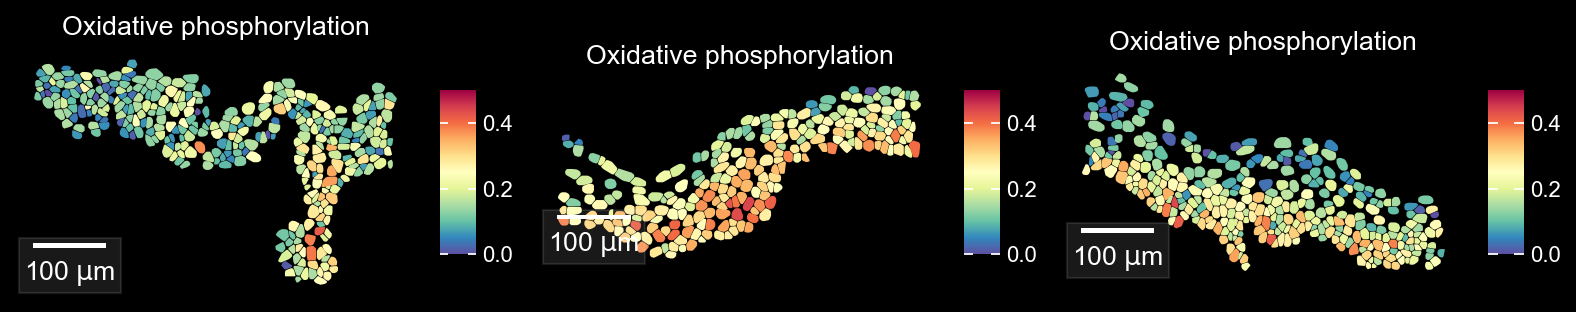

In [201]:
zone = {
'HC2' : [14600,18500,15600,19400],
'DLE4' : [11500,15800,12500,16800],
'SLE2' : [18000,17400,19000,18000]
}

rows, cols = 1, 3
fig = None
axs = None
plot_count = 0

samples = ["HC2","DLE4","SLE2"]
for i in range(len(samples)):
    sample_adata = ST_adata[(ST_adata.obs['sample'] == samples[i]) & (ST_adata.obs['Region'] == 'Epi')]
    sc.tl.score_genes(sample_adata, OP_gene['Genesymbol'], score_name ='OP_score', ctrl_size=100)

    zone_adata = within(sample_adata, zone[samples[i]], reduction='contour', inplace=True)
        
    if plot_count % (rows*cols) == 0:
        with mpl.style.context('dark_background'):
            if fig is not None:
                plt.tight_layout(pad=1.0)
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)
            fig = plt.figure(figsize=(10, 4))
            axs = fig.subplots(rows, cols)
            axs = axs.ravel()   
    ax = axs[plot_count % (rows*cols)]
    
    ax = featureplot(zone_adata, features='OP_score', reduction='contour', dot_size=100, vmin = 0, vmax = 0.5,vcenter=0.25, ax=ax, style='dark_background')
    draw_scalebar(ax=ax, color='white', location='lower left')
    ax.set_title(f"Oxidative phosphorylation")
    plot_count += 1
if fig is not None:
    for j in range(plot_count % (rows*cols), rows*cols):
        axs[j].axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()

In [170]:
INFA_gene = Hallmark_gene[Hallmark_gene['HallmarkName'] == 'HALLMARK_INTERFERON_ALPHA_RESPONSE']

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:42:45] ❕  ssat is not registered, register now                                           ]8;id=871898;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=522604;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


           ❕  ssat is not registered, register now                                           ]8;id=944975;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=383042;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:42:46] ❕  ssat is not registered, register now                                           ]8;id=604212;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=545374;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

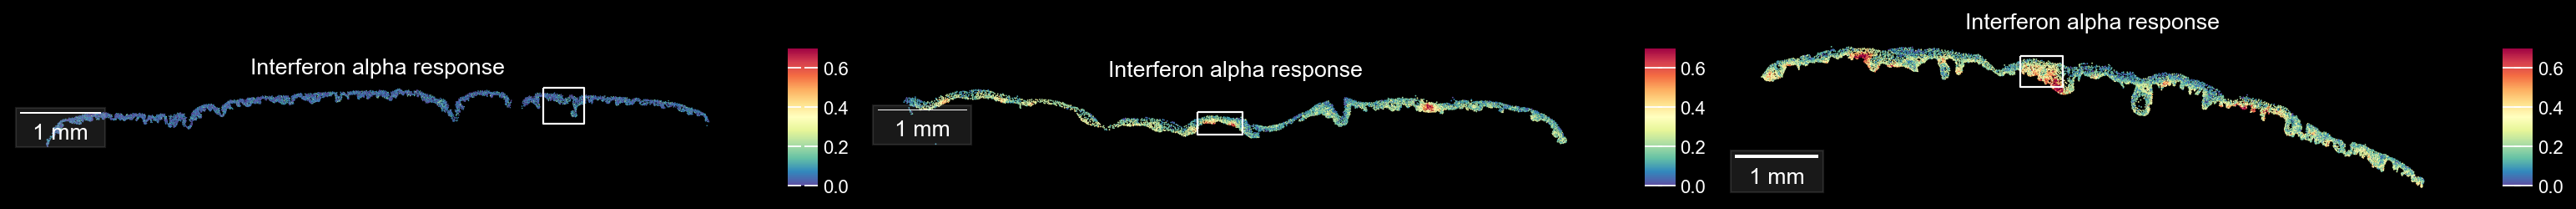

In [200]:
polygons = {
    "HC2": [Polygon([[14600, 19400], [15600, 19400], [15600, 18500], [14600, 18500]])],
    "DLE4": [Polygon([[12100, 16800], [13100, 16800], [13100, 16300], [12100, 16300]])],
    "SLE2": [Polygon([[16000,18150], [17000,18150],[17000,17400], [16000,17400]])] 
}

rows, cols = 1, 3
fig = None
axs = None
plot_count = 0

samples = ["HC2","DLE4","SLE2"]
for i in range(len(samples)):
    sample_adata = ST_adata[(ST_adata.obs['sample'] == samples[i]) & (ST_adata.obs['Region'] == 'Epi')]
    sc.tl.score_genes(sample_adata, INFA_gene['Genesymbol'], score_name ='INFA_score', ctrl_size=100)
    
    if plot_count % (rows*cols) == 0:
        with mpl.style.context('dark_background'):
            if fig is not None:
                plt.tight_layout(pad=1.0)
                plt.close(fig)
            fig = plt.figure(figsize=(20, 4))
            axs = fig.subplots(rows, cols)
            axs = axs.ravel()   
    ax = axs[plot_count % (rows*cols)]
    
    ax = featureplot(sample_adata, features='INFA_score', reduction='spatial', dot_size=100, vmin = 0, vmax = 0.7,vcenter=0.35, ax=ax, style='dark_background')
    draw_scalebar(ax=ax, color='white', location='lower left')
    ax.set_title(f"Interferon alpha response")
    for polygon in polygons[samples[i]]:
        gpd.GeoSeries(polygon).plot(ax=ax, edgecolor='white',facecolor='none', linewidth=1) #linestyle='--',
    plot_count += 1
    
if fig is not None:
    for j in range(plot_count % (rows*cols), rows*cols):
        axs[j].axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()

/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:42:35] 📃  Filtering contour within bounding box [14600, 18500, 15600, 19400]            ]8;id=788936;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=198612;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=728265;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=643174;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


[17:42:36] 📃  Filtering contour within bounding box [12100, 16300, 13100, 16800]            ]8;id=351986;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=374389;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=528065;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=16636;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/share/appspace_data/shared_groups/bgi_zhangzh_jszx/.conda/envs/py38/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:178: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


           📃  Filtering contour within bounding box [16000, 17400, 17000, 18150]            ]8;id=145295;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=959950;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=809893;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=899492;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


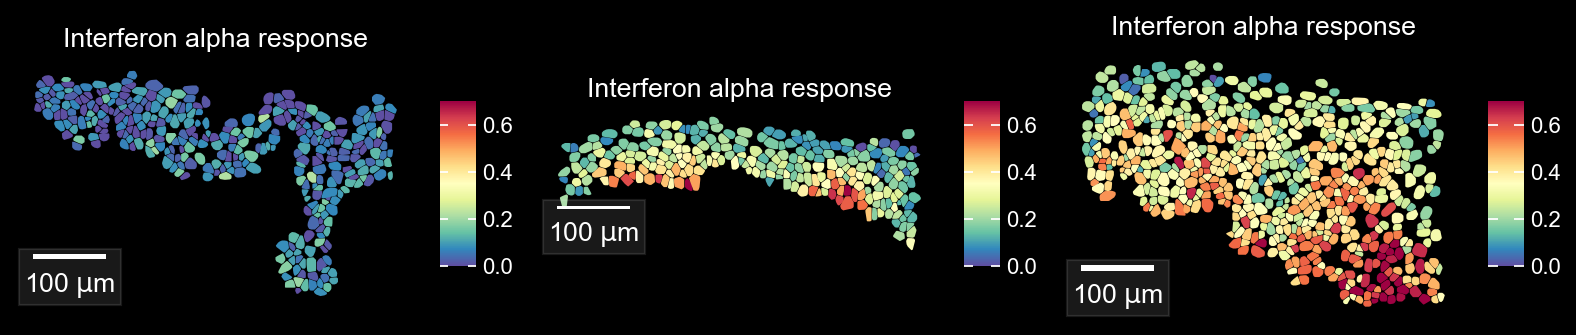

In [199]:
zone = {
'HC2' : [14600,18500,15600,19400],
'DLE4' : [12100,16300,13100,16800],
'SLE2' : [16000,17400,17000,18150]
}

rows, cols = 1, 3
fig = None
axs = None
plot_count = 0

samples = ["HC2","DLE4","SLE2"]
for i in range(len(samples)):
    sample_adata = ST_adata[(ST_adata.obs['sample'] == samples[i]) & (ST_adata.obs['Region'] == 'Epi')]
    sc.tl.score_genes(sample_adata, INFA_gene['Genesymbol'], score_name ='INFA_score', ctrl_size=100)
 
    zone_adata = within(sample_adata, zone[samples[i]], reduction='contour', inplace=True)

    if plot_count % (rows*cols) == 0:
        with mpl.style.context('dark_background'):
            if fig is not None:
                plt.tight_layout(pad=1.0)
                plt.close(fig)
            fig = plt.figure(figsize=(10, 4))
            axs = fig.subplots(rows, cols)
            axs = axs.ravel()   
    ax = axs[plot_count % (rows*cols)]
    
    ax = featureplot(zone_adata, features='INFA_score', reduction='contour', dot_size=100, vmin = 0, vmax = 0.7,vcenter=0.35, ax=ax, style="dark_background") #
    draw_scalebar(ax=ax, color='white', location='lower left')
    ax.set_title(f"Interferon alpha response")
    plot_count += 1
if fig is not None:
    for j in range(plot_count % (rows*cols), rows*cols):
        axs[j].axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()

## Fig.2I

In [240]:
genes_plot = ['IL36G', 'CXCL10', 'IFIH1']
samples = ["HC2","DLE4","SLE2"]

In [241]:
polygons = {
    "HC2": [Polygon([[10000, 19400], [11000, 19400], [11000, 18400], [10000, 18400]])],
    "DLE4": [Polygon([[11500, 16800], [12500, 16800], [12500, 15800], [11500, 15800]])],
    "SLE2_1": [Polygon([[12200, 18400], [13200, 18400], [13200, 17400], [12200, 17400]])], #IL36G
    "SLE2": [Polygon([[11700,18400], [12700,18400],[12700,17400], [11700,17400]])] #CXCL10, IFIH1
}

[18:25:44] ❕  ssat is not registered, register now                                           ]8;id=934643;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=215204;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:45] ❕  ssat is not registered, register now                                           ]8;id=994932;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=687913;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:46] ❕  ssat is not registered, register now                                           ]8;id=290356;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=433675;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:47] ❕  ssat is not registered, register now                                           ]8;id=502948;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=820311;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


           ❕  ssat is not registered, register now                                           ]8;id=826478;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=670120;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:48] ❕  ssat is not registered, register now                                           ]8;id=602385;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=230573;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:50] ❕  ssat is not registered, register now                                           ]8;id=716606;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=386371;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:51] ❕  ssat is not registered, register now                                           ]8;id=863102;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=259033;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:25:52] ❕  ssat is not registered, register now                                           ]8;id=312635;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=248357;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


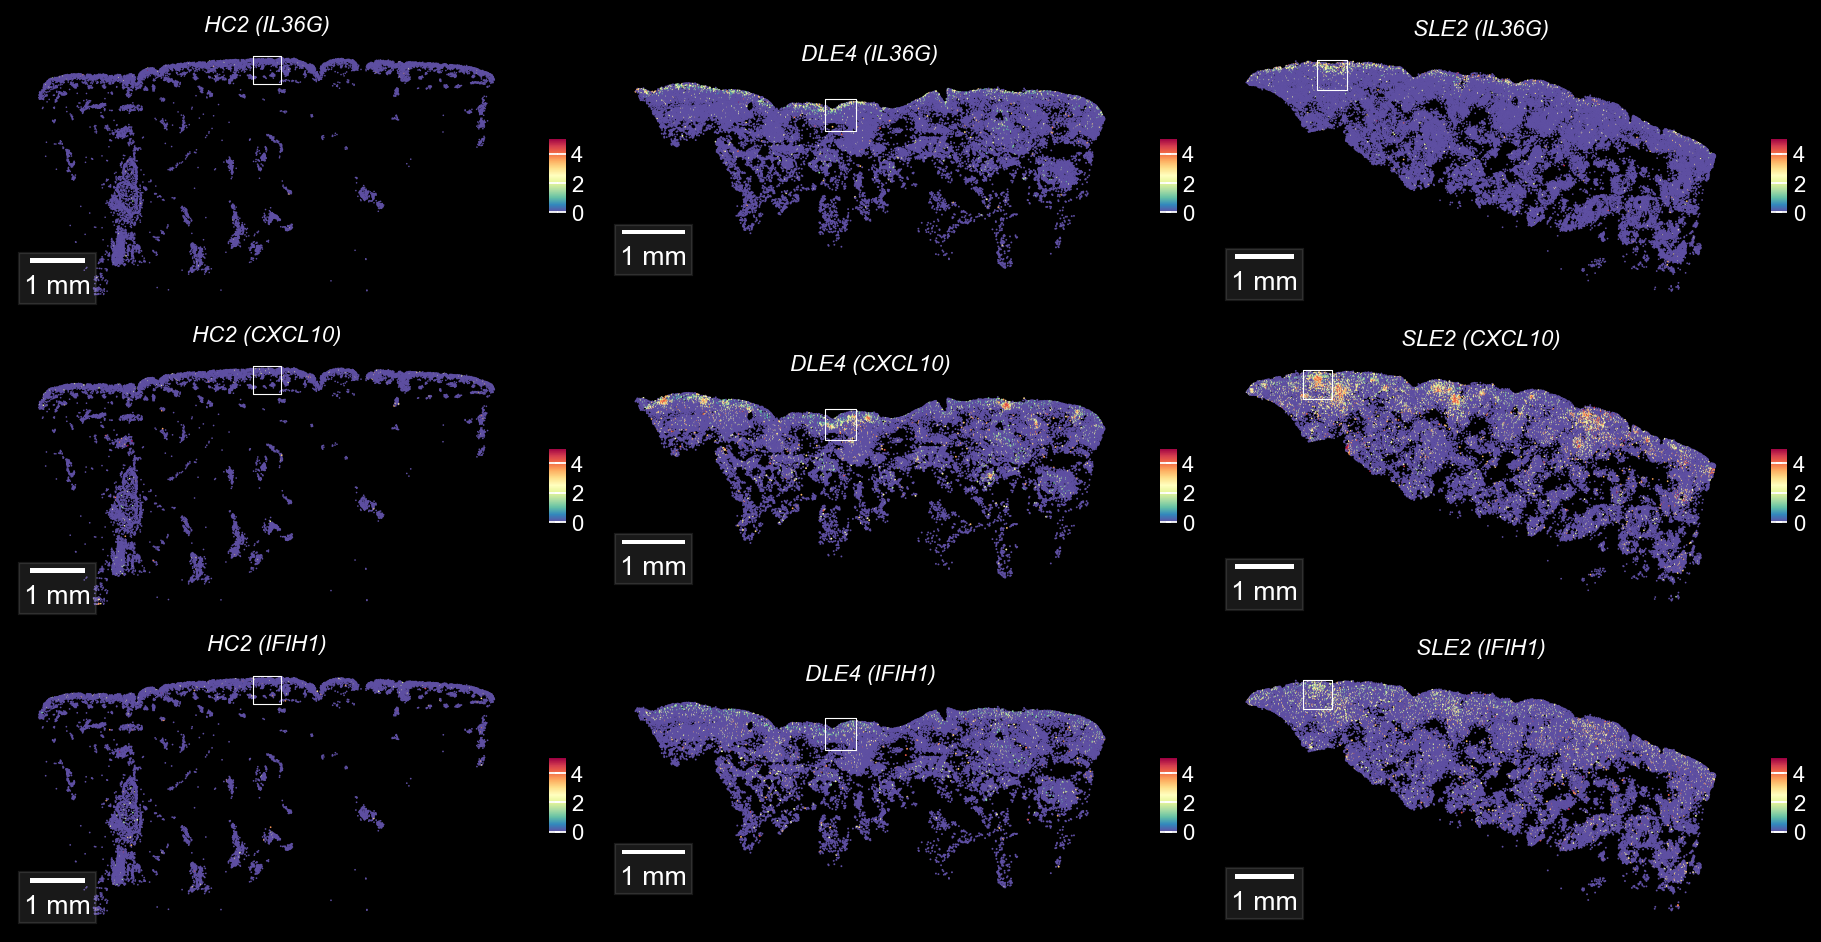

In [239]:
n_genes = len(genes_plot)
n_samples = len(samples)

with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(
        nrows=n_genes,
        ncols=n_samples,
        figsize=(4 * n_samples, 2 * n_genes),
        squeeze=False
    )

    for i, gene in enumerate(genes_plot):   
        for j, sample in enumerate(samples):    
            ax = axs[i, j]

            sample_adata = ST_adata[ST_adata.obs["sample"] == sample]
            if gene == 'IL36G' and sample == 'SLE2':
                polygon = polygons['SLE2_1']
            else:
                polygon = polygons[sample]
            ax = featureplot(sample_adata,features=gene,reduction="spatial", ax=ax, dot_size=200,style="dark_background",  vmax=5)
            draw_scalebar(ax=ax, color='white', location='lower left')
            gpd.GeoSeries(polygon).plot(ax=ax, edgecolor='white',facecolor='none', linewidth=0.5)
            ax.set_title(f"{sample} ({gene})", fontsize=10)  
            ax.axis("off")

    plt.tight_layout(pad=1.0)
    plt.show()

[18:29:27] 📃  Filtering contour within bounding box [10000, 18400, 11000, 19400]            ]8;id=84334;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=177309;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=481074;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=182021;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:28] 📃  Filtering contour within bounding box [11500, 15800, 12500, 16800]            ]8;id=317867;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=35038;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=325959;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=493236;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:29] 📃  Filtering contour within bounding box [12200, 17400, 13200, 18400]            ]8;id=702499;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=963716;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=393589;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=435568;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:30] 📃  Filtering contour within bounding box [10000, 18400, 11000, 19400]            ]8;id=70121;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=306412;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=707794;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=121196;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:31] 📃  Filtering contour within bounding box [11500, 15800, 12500, 16800]            ]8;id=654050;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=49068;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=405402;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=97340;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:32] 📃  Filtering contour within bounding box [11700, 17400, 12700, 18400]            ]8;id=579205;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=956067;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=705150;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=735744;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:33] 📃  Filtering contour within bounding box [10000, 18400, 11000, 19400]            ]8;id=739647;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=418017;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=677109;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=538653;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:34] 📃  Filtering contour within bounding box [11500, 15800, 12500, 16800]            ]8;id=202280;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=925230;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=330578;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=264513;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


[18:29:35] 📃  Filtering contour within bounding box [11700, 17400, 12700, 18400]            ]8;id=908672;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=490043;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#2645\2645]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=535461;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py\utils_20250718.py]8;;\:]8;id=155770;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py#278\278]8;;\

/share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Figure2/utils_20250718.py:279: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


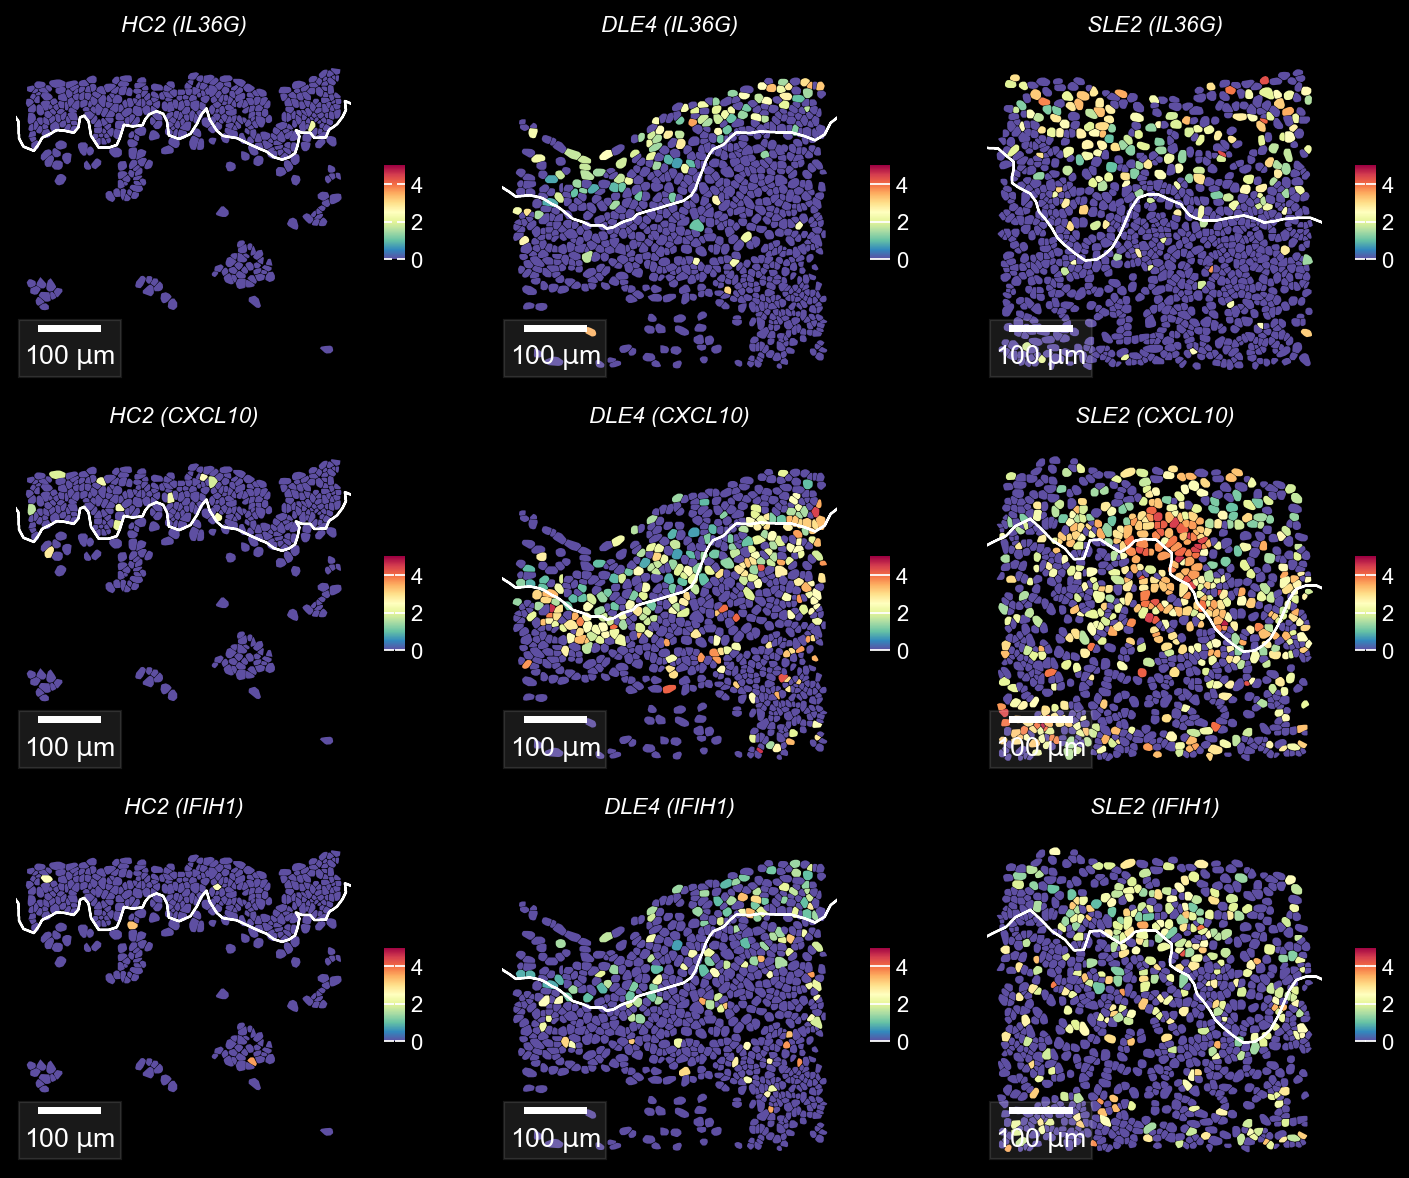

In [244]:
zone = {'HC2' : [10000,18400,11000,19400],
'DLE4' : [11500,15800,12500,16800],
'SLE2_1' : [12200,17400,13200,18400], #IL36G
'SLE2' : [11700,17400,12700,18400] #CXCL10, IFIH1
}

n_genes = len(genes_plot)
n_samples = len(samples)

with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(
        nrows=n_genes,
        ncols=n_samples,
        figsize=(3.5 * n_samples, 2.5 * n_genes),
        squeeze=False
    )

    for i, gene in enumerate(genes_plot):   
        for j, sample in enumerate(samples):    
            ax = axs[i, j]
            BM_shp= gpd.read_file(f"{sample}_BM_tussue_contour.shp")     
            sample_adata = ST_adata[ST_adata.obs["sample"] == sample]
            if gene == 'IL36G' and sample == 'SLE2':
                zone_adata = within(sample_adata, zone['SLE2_1'], reduction='contour', inplace=True)
                zone_sample = zone['SLE2_1']
            else:
                zone_adata = within(sample_adata, zone[sample], reduction='contour', inplace=True)
                zone_sample = zone[sample]
            ax = featureplot(zone_adata,features=gene,reduction="contour", ax=ax, style="dark_background", vmax=5)
            BM_shp.plot(ax=ax, edgecolor='white',facecolor='none', linewidth=1)
            draw_scalebar(ax=ax, color='white', location='lower left')
            ax.set_title(f"{sample} ({gene})", fontsize=10)  
            ax.set_xlim([zone_sample[0]-30,zone_sample[2]+30])
            ax.set_ylim([zone_sample[1]-30,zone_sample[3]+30])
            ax.axis("off")

    plt.tight_layout(pad=1.0)
    plt.show()